In [1]:
# IMPORTING REQUIRED PACKAGES
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# DEFINE VARIABLE
BATCH_SIZE = 32                 # YOU MAY CHANGE THIS VALUE
EPOCH_NUM = 25                  # YOU MAY CHANGE THIS VALUE
LR = 0.001                      # YOU MAY CHANGE THIS VALUE
MODEL_SAVE_PATH = './Models'

if not os.path.exists(MODEL_SAVE_PATH):
    os.mkdir(MODEL_SAVE_PATH)

In [3]:
# DEFINING TRANSFORM TO APPLY TO THE IMAGES
# YOU MAY ADD OTHER TRANSFORMS FOR DATA AUGMENTATION
transform = transforms.Compose(
    [transforms.Resize(32),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



In [4]:
########################################################################
# 1. LOAD AND NORMALIZE CIFAR10 DATASET
########################################################################

#FILL IN: Get train and test dataset from torchvision and create respective dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:02<00:00, 75848893.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
########################################################################
# 2. DEFINE YOUR CONVOLUTIONAL NEURAL NETWORK AND IMPORT IT
########################################################################

class ConvNet(nn.Module):
    def __init__(self, init_weights=False):
        super(ConvNet, self).__init__()

        # INITIALIZE LAYERS HERE
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.25)
        # self.fc = nn.Linear(256 * 2 * 2, 10)
        self.fc = nn.Linear(1024, 10)


        if init_weights:
            self._initialize_weights()

    def forward(self, x):
    # Pass image x through each layer defined above
      x = self.conv1(x)
      x = self.bn1(x)
      x = F.relu(x)
      x = self.pool(x)
      x = self.dropout(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x = F.relu(x)
      x = self.pool(x)
      x = self.dropout(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x = F.relu(x)
      x = self.pool(x)
      x = self.dropout(x)

      x = self.conv4(x)
      x = self.bn4(x)
      x = F.relu(x)
      x = self.pool(x)
      x = self.dropout(x)

      # print(f"Flattened shape: {x.view(x.size(0), -1).shape}")

      # print(f"Shape before flattening: {x.shape}")

      # Flatten the output before passing it to the fully connected layer
      x = x.view(-1, 256 * 4 * 4)

      out = self.fc(x)
      return out

    def forward(self, x):
    # Pass image x through each layer defined above
      x = self.conv1(x)
      x = self.bn1(x)
      x = F.relu(x)
      x = self.pool(x)
      x = self.dropout(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x = F.relu(x)
      x = self.pool(x)
      x = self.dropout(x)

      x = self.conv3(x)
      x = self.bn3(x)
      x = F.relu(x)
      x = self.pool(x)
      x = self.dropout(x)

      x = self.conv4(x)
      x = self.bn4(x)
      x = F.relu(x)
      x = self.pool(x)
      x = self.dropout(x)

      # print(f"Shape before flattening: {x.shape}")

      # Flatten the output before passing it to the fully connected layer
      x = x.view(x.size(0), -1)
      # print(f"Flattened shape: {x.shape}")

      out = self.fc(x)
      return out


    def _initialize_weights(self):
        # INITIALIZE WEIGHTS
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ConvNet().to(device)
#MAKE SURE TO DEFINE ConvNet IN A CELL ABOVE THE STARTER CODE OF WHICH IS IN cnn_model.py
#You can pass arguments to ConvNet if you want instead of hard coding them.

In [7]:
########################################################################
# 3. DEFINE A LOSS FUNCTION AND OPTIMIZER
########################################################################

#FILL IN : the criteria for ce loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

In [8]:
########################################################################
# 4. TRAIN THE NETWORK
########################################################################

test_accuracy = []
train_accuracy = []
train_loss = []
net.train()

for epoch in range(EPOCH_NUM):  # loop over the dataset multiple times

    running_loss = 0.0
    test_min_acc = 0
    total = 0
    correct = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # print(f"Batch {i+1}: Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")

        # print(f"Batch size of inputs: {inputs.size(0)}")
        # print(f"Batch size of labels: {labels.size(0)}")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        # print(f"Output shape: {outputs.shape}")

        # if outputs.size(0) != labels.size(0):
            # print(f"Mismatch: outputs size {outputs.size(0)}, labels size {labels.size(0)}")
            # continue

        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        # FILL IN: Obtain accuracy for the given batch of TRAINING data using
        # the formula acc = 100.0 * correct / total where
        # total is the total number of images processed so far
        # correct is the correctly classified images so far

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        train_loss.append(running_loss/20)
        train_accuracy.append(100.0*correct/total)

        if i % 100 == 0:
            print('Train: [%d, %5d] loss: %.3f acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20,100.0*correct/total))
            running_loss = 0.0

    # TEST LEARNT MODEL ON ENTIRE TESTSET
    # FILL IN: to get test accuracy on the entire testset and append
    # it to the list test_accuracy

    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    test_accuracy.append(100.0 * correct / total)
    net.train()

    test_ep_acc = test_accuracy[-1]
    print('Test Accuracy: %.3f %%' % (test_ep_acc))

    # SAVE BEST MODEL
    if test_min_acc < test_ep_acc:
        test_min_acc = test_ep_acc
        torch.save(net, MODEL_SAVE_PATH + '/my_best_model.pth')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train: [1,     1] loss: 0.124 acc: 12.500
Train: [1,   101] loss: 10.793 acc: 22.432
Train: [1,   201] loss: 9.305 acc: 27.146
Train: [1,   301] loss: 8.482 acc: 30.990
Train: [1,   401] loss: 8.426 acc: 33.206
Train: [1,   501] loss: 8.241 acc: 34.481
Train: [1,   601] loss: 7.955 acc: 35.607
Train: [1,   701] loss: 7.882 acc: 36.591
Train: [1,   801] loss: 7.663 acc: 37.438
Train: [1,   901] loss: 7.503 acc: 38.301
Train: [1,  1001] loss: 7.623 acc: 38.833
Train: [1,  1101] loss: 7.406 acc: 39.566
Train: [1,  1201] loss: 7.405 acc: 40.180
Train: [1,  1301] loss: 7.089 acc: 40.834
Train: [1,  1401] loss: 7.207 acc: 41.294
Train: [1,  1501] loss: 7.046 acc: 41.826


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy: 43.200 %
Train: [2,     1] loss: 0.063 acc: 46.875
Train: [2,   101] loss: 6.837 acc: 50.650
Train: [2,   201] loss: 6.744 acc: 51.026
Train: [2,   301] loss: 6.600 acc: 51.360
Train: [2,   401] loss: 6.710 acc: 51.309
Train: [2,   501] loss: 6.573 acc: 51.715
Train: [2,   601] loss: 6.528 acc: 52.023
Train: [2,   701] loss: 6.439 acc: 52.149
Train: [2,   801] loss: 6.351 acc: 52.302
Train: [2,   901] loss: 6.434 acc: 52.452
Train: [2,  1001] loss: 6.229 acc: 52.878
Train: [2,  1101] loss: 6.186 acc: 53.088
Train: [2,  1201] loss: 6.195 acc: 53.320
Train: [2,  1301] loss: 6.237 acc: 53.543
Train: [2,  1401] loss: 6.140 acc: 53.689
Train: [2,  1501] loss: 6.292 acc: 53.793
Test Accuracy: 50.420 %
Train: [3,     1] loss: 0.071 acc: 43.750
Train: [3,   101] loss: 6.151 acc: 56.157
Train: [3,   201] loss: 5.994 acc: 56.965
Train: [3,   301] loss: 5.844 acc: 57.558
Train: [3,   401] loss: 5.940 acc: 57.372
Train: [3,   501] loss: 5.934 acc: 57.516
Train: [3,   601] loss: 5.95

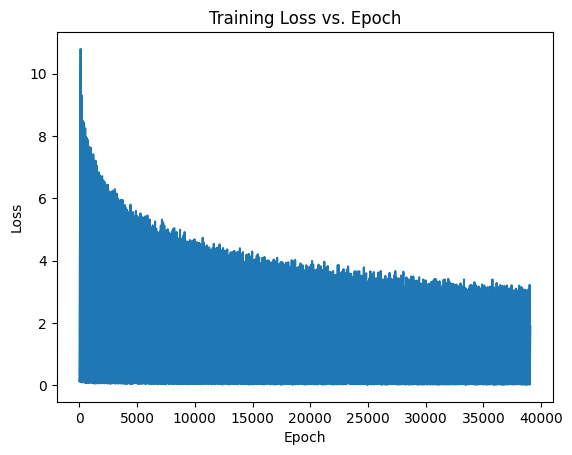

In [9]:
# PLOT THE TRAINING LOSS VS EPOCH GRAPH
plt.figure()
plt.plot(train_loss)
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

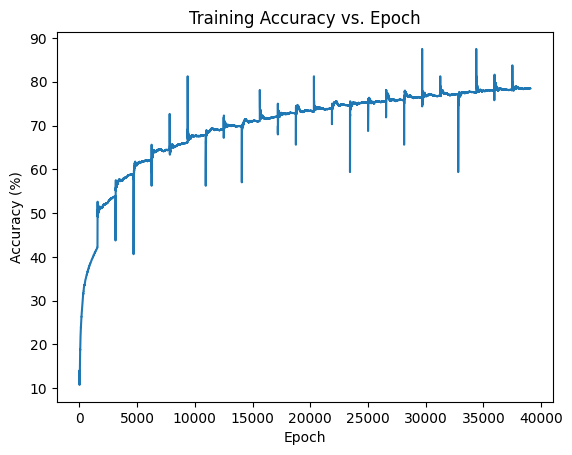

In [10]:
# PLOT THE TRAINING ACCURACY VS EPOCH GRAPH
plt.figure()
plt.plot(train_accuracy)
plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

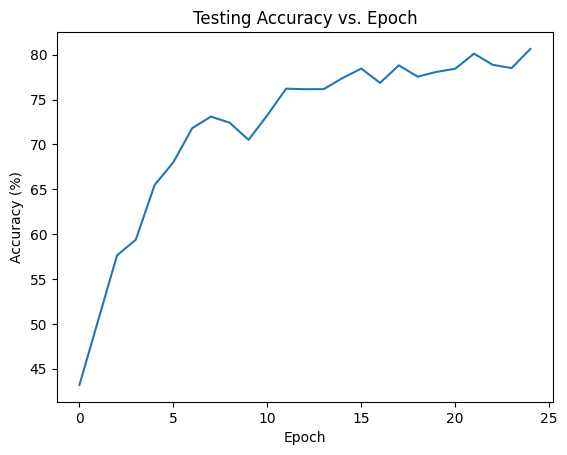

In [11]:
# PLOT THE TESTING ACCURACY VS EPOCH GRAPH
plt.figure()
plt.plot(test_accuracy)
plt.title('Testing Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()


In [12]:
# PRINT THE FINAL TESTING ACCURACY OF YOUR BEST MODEL
print('Final Testing Accuracy: %.3f %%' % (max(test_accuracy)))

print('Finished Training')

Final Testing Accuracy: 80.650 %
Finished Training
